### I. Data Collection

#### 1. Chủ đề

- Bộ dữ liệu ghi nhận các vụ việc liên quan đến cá mập và con người tại Úc, bao gồm các vụ tấn công, va chạm hoặc cố gắng cắn.

- Chủ đề thuộc lĩnh vực động vật hoang dã, sinh thái biển và an toàn con người, phản ánh bối cảnh thực tế ngoài đời sống, giúp nghiên cứu hành vi cá mập, mức độ nguy hiểm, yếu tố môi trường và rủi ro đối với con người khi tham gia các hoạt động dưới nước.

#### 2. Nguồn dữ liệu

- Bộ dữ liệu: [Australian Shark-Incident Database (ASID)](https://taronga.org.au/conservation-and-science/australian-shark-incident-database)

- Tổ chức quản lý và thu thập: Taronga Conservation Society Australia, phối hợp với Flinders University và NSW Department of Primary Industries.

- Thời gian thu thập kéo dài từ 1791 đến hiện tại, được cập nhật theo từng năm.

#### 3. Giấy phép và quyền sử dụng

- Bộ dữ liệu được chia sẻ công khai theo giấy phép mở thông qua GitHub của ASID ([GitHub – AustralianSharkIncidentDatabase](https://github.com/cjabradshaw/AustralianSharkIncidentDatabase)).

- Người sử dụng được phép dùng cho mục đích học thuật, nghiên cứu và các phân tích khoa học.

- Khi sử dụng hoặc trích dẫn cần ghi rõ nguồn gốc: "Australian Shark-Incident Database, Taronga Conservation Society Australia"

- Không có giới hạn thương mại cụ thể nhưng phải đảm bảo giữ nguyên tính toàn vẹn nội dung và ghi nhận nguồn theo quy định.

#### 4. Phương pháp thu thập dữ liệu

- Dữ liệu được tổng hợp từ nhiều nguồn:

    - báo cáo của nhân chứng/nạn nhân

    - báo chí, truyền thông

    - báo cáo chính thức từ cơ quan thủy sản, cảnh sát, y tế

    - hồ sơ điều tra thực địa

- Sau khi tiếp nhận thông tin, Taronga tiến hành xác minh bằng khảo sát, phỏng vấn, báo cáo y tế và điều tra độc lập.

- Đối tượng khảo sát: các vụ việc có con người tham gia hoạt động dưới nước hoặc phương tiện nhỏ (surfboard, kayak, lặn…).

- Các vụ việc chỉ được đưa vào database nếu đáp ứng 3 tiêu chí: 
    - (i) người còn sống tại thời điểm xảy ra vụ.
    - (ii) người đang ở trong nước hoặc sử dụng phương tiện nhỏ như kayak, surfboard...
    - (iii) có biểu hiện rõ ràng của cá mập cắn người, thiết bị hoặc phương tiện nhỏ. Có thể ghi lại dù vết cắn không thành công (bumped, attempted bite). 

- Thời gian thu thập: hơn 230 năm dữ liệu lịch sử (từ 1791 đến nay).

- Hạn chế tiềm ẩn:

    - dữ liệu trước thế kỷ 20 có thể thiếu chính xác do báo cáo không đầy đủ

    - có thể tồn tại bias từ báo chí hoặc nhân chứng

    - không phải vụ việc nào cũng xác định được loài cá mập

#### 5. Lý do chọn bộ dữ liệu

- Chủ đề mới lạ, mang tính thực tiễn, gần gũi với vấn đề an toàn con người trong tự nhiên.

- Dữ liệu có nhiều biến phong phú, cho phép khai thác nhiều hướng phân tích.

- Thông tin cung cấp có nhiều khía cạnh cần xử lí, phù hợp với tính chất môn học và đồ án.

- Bộ dữ liệu phù hợp với mục tiêu nghiên cứu khoa học dữ liệu của nhóm, có thể đưa ra nhận định, trực quan hóa và khám phá kiến thức mới.

## DATA EXPLORATION

In [73]:
# Import thư viện, load dữ liệu và chuẩn hóa tên cột

import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập hiển thị 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Hàm chuẩn hóa tên cột: bỏ ký tự đặc biệt, khoảng trắng, đổi sang lowercase
def clean_col_name(c):
    c = c.strip()
    c = c.replace(" ", "_").replace(".", "_").replace("/", "_")
    c = c.replace("(", "").replace(")", "").replace("<", "lt_").replace(">", "gt_")
    while "__" in c:
        c = c.replace("__", "_")
    return c.lower().strip("_")

data_path = "data/raw/SharkIncident.csv"
df = pd.read_csv(data_path, low_memory=False)

# Số dòng và cột
print("- Số dòng:", df.shape[0])
print("- Số cột:", df.shape[1])

# Chuẩn hóa tên các cột
df.columns = [clean_col_name(c) for c in df.columns]

print("- 5 dòng đầu:")
display(df.head())

- Số dòng: 1283
- Số cột: 60
- 5 dòng đầu:


,uin,incident_month,incident_year,victim_injury,state,location,latitude,longitude,site_category,site_category_comment,shark_common_name,shark_scientific_name,shark_identification_method,shark_identification_source,shark_length_m,basis_for_length,provoked_unprovoked,provocative_act,no_sharks,victim_activity,fish_speared?,commercial_dive_activity,object_of_bite,present_at_time_of_bite,direction_first_strike,shark_behaviour,victim_aware_of_shark,shark_captured,injury_location,injury_severity,victim_gender,victim_age,victim_clothing,clothing_coverage,dominant_clothing_colour,other_clothing_colour,clothing_pattern,fin_colour,diversionary_action_taken,diversionary_action_outcome,people_lt_3m,people_3-15m,time_of_incident,depth_of_incident_m,teeth_recovered,time_in_water_min,water_temperature_°c,total_water_depth_m,water_visability_m,distance_to_shore_m,spring_or_neap_tide,tidal_cycle,wind_condition,weather_condition,air_temperature_°c,personal_protective_device,deterrent_brand_and_type,data_source,reference,unnamed:_59
0,1,1,1791,fatal,NSW,sydney (near),-33.86,151.2000,coastal,NaN,white shark,Carcharodon carcharias,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,NaN,swimming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,torso,major lacerations,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"shark&survl, whitley 1958, book ref 1793",NaN
1,2,3,1803,injured,WA,"shark bay, faure island",-25.8826,113.9226,coastal,bay to open ocean,tiger shark,Galeocerdo cuvier,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,swam at victim,Y,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pushed at shark,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"balgridge,green,taylor,whitley 1940",NaN
2,3,1,1807,injured,NSW,"sydney harbour, cockle bay",-33.8661,151.2010,estuary/harbour,bay,bull shark,Carcharhinus leucas,"bite analysis, shark behaviour",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,bit victim on wrist,NaN,NaN,"arm, hand",minor lacerations,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,sydney gazette 18.1.1807,NaN
3,4,1,1820,fatal,TAS,"sweetwater point, pitt water",-42.8025,147.4868,estuary/harbour,bay to open ocean,NaN,NaN,NaN,NaN,NaN,NaN,provoked,NaN,1.0,swimming,NaN,NaN,NaN,catch,NaN,bit victim on leg,N,NaN,leg,major lacerations,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,witness account,"shark&survl, c. black researcher",NaN
4,5,1,1825,injured,NSW,"sydney harbour, kirribili point",-33.8527,151.2188,estuary/harbour,harbour,bull shark,Carcharhinus leucas,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,bit legs,NaN,NaN,leg,minor lacerations,male,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,maitland daily mercury 13.11.1899,NaN


#### Thông tin cơ bản
- Dữ liệu gốc gồm: 1283 dòng và 60 cột.

- Mỗi dòng tương ứng một vụ việc — gồm thông tin về thời gian (tháng, năm), vị trí (latitude, longitude, bang/tiểu bang, địa điểm cụ thể), tình trạng nạn nhân (thương tích, tử vong, không bị thương), loài cá mập nếu biết, hoạt động của nạn nhân lúc xảy ra vụ việc, và nhiều biến khác liên quan: điều kiện nước, thời tiết, hoạt động lặn/câu cá, sự kiện kích động (provoked / unprovoked), thông tin về thiết bị bảo hộ, v.v.

- Dữ liệu ban đầu được lưu dưới dạng .xlsl, được chuyển về .csv và có tổng kích thước 436KB.

In [74]:
# Kiểm tra duplicated rows
dups = df.duplicated()
print(f"\n- Số dòng trùng lặp: {dups.sum()}")


- Số dòng trùng lặp: 0


- Không có dòng dữ liệu nào trùng lặp.

In [75]:
# Kiểu dữ liệu của từng cột và số missing values

col_info = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_count": df.isna().sum(),
    "missing_%": round(df.isna().mean() * 100, 2)
})
display(col_info)

,dtype,missing_count,missing_%
uin,int64,0,0.00
incident_month,int64,0,0.00
incident_year,int64,0,0.00
victim_injury,object,0,0.00
state,object,0,0.00
location,object,0,0.00
latitude,object,0,0.00
longitude,float64,0,0.00
site_category,object,0,0.00
site_category_comment,object,558,43.49


#### Bảng thống kê biến và ý nghĩa của biến:

| Tên cột                                                                 | Ý nghĩa                                                                         |
| ------------------------------------------------------------------------ | ------------------------------------------------------------------------------- |
| **uin**                                                                  | Mã định danh duy nhất cho mỗi vụ việc.                 |
| **incident_month**                                                       | Tháng xảy ra vụ việc.                              |
| **incident_year**                                                        | Năm xảy ra vụ việc(yyyy).                                                               |
| **victim_injury**                                                        | Loại thương tích (fatal / injured / uninjured)                                 |
| **state**                                                                | Bang/khu vực địa lý nơi vụ việc xảy ra.                                         |
| **location**                                                             | Địa điểm cụ thể hơn của sự cố (bãi biển, vùng biển…).                           |
| **latitude**, **longitude**                                              | Toạ độ địa lý của vụ tấn công.                                                  |
| **site_category**, **site_category_comment**                             | Loại địa điểm (bơi, lặn, câu cá…) + ghi chú bổ sung.                            |
| **shark_common_name**                                                    | Tên thông thường của loài cá mập liên quan tới sự cố.                             |
| **shark_scientific_name**                                                | Tên khoa học của loài cá mập liên quan tới sự cố.                                              |
| **shark_identification_method**                                          | Phương pháp xác định loài (DNA, răng, vết cắn, hành vi…).                          |
| **shark_identification_source**                                          | Nguồn xác nhận thông tin loài (báo cáo, nhân chứng…).                           |
| **shark_length_m**                                                       | Chiều dài ước tính của cá mập (m).                                              |
| **basis_for_length**                                                     | Cơ sở để ước lượng chiều dài (quan sát, đo đạc, camera…).                       |
| **provoked_unprovoked**                                                  | Vụ tấn công mang tính tự nhiên hay bị kích động (unprovoked / provoked).        |
| **provocative_act**                                                      | Hành động cụ thể gây kích động (nếu có).                                        |
| **no_sharks**                                                            | Số lượng cá mập xuất hiện.                                  |
| **victim_activity**                                                      | Nạn nhân đang làm gì tại thời điểm bị tấn công (bơi, lướt ván…).                |
| **fish_speared?**                                                        | Cá mập có bị tấn công/thương tích hay không. |
| **commercial_dive_activity**                                             | Hoạt động lặn có mang tính thương mại/tour hay cá nhân.                         |
| **object_of_bite**                                                       | Bộ phận bị cá mập cắn: người, ván lướt, thuyền…                                 |
| **present_at_time_of_bite**                                              | Những gì xuất hiện cạnh nạn nhân (đàn cá, chim biển…).                          |
| **direction_first_strike**                                               | Hướng tiếp cận ban đầu của cá mập.                                              |
| **shark_behaviour**                                                      | Hành vi quan sát được (rình rập, bơi vòng…).                                    |
| **victim_aware_of_shark**                                                | Nạn nhân có phát hiện cá mập trước khi bị cắn hay không.                        |
| **shark_captured**                                                       | Cá mập có bị bắt lại sau sự cố hay không.                                       |
| **injury_location**                                                      | Vị trí thương tích trên cơ thể.                                                 |
| **injury_severity**                                                      | Mức độ thương tích (nhẹ, trung bình, nghiêm trọng, tử vong…).                   |
| **victim_gender**, **victim_age**                                        | Giới tính và độ tuổi nạn nhân.                                                   |
| **victim_clothing**, **clothing_coverage**, **dominant_clothing_colour** | Thông tin trang phục.          |
| **other_clothing_colour**, **clothing_pattern**                          | Màu sắc/phối hoa văn phụ của trang phục.                                   |
| **fin_colour**                                                           | Màu vây/flippers của nạn nhân(>=2 màu = multicolour).                                                   |
| **diversionary_action_taken**                                            | Nạn nhân/xung quanh có hành động xua đuổi không.                                |
| **diversionary_action_outcome**                                          | Kết quả hành động xua đuổi đó.                                                           |
| **people_lt_3m**, **people_3-15m**                                       | Số người có mặt gần nạn nhân trong bán kính 3m hoặc 3–15m.                      |
| **time_of_incident**                                                     | Thời điểm xảy ra sự cố (định dạng ví dụ: 1830).                               |
| **depth_of_incident_m**, **total_water_depth_m**                         | Độ sâu nơi xảy ra sự cố và độ sâu tổng khu vực.                                  |
| **teeth_recovered**                                                      | Có thu hồi được răng/mảnh răng nào không.                 |
| **time_in_water_min**                                                    | Thời gian nạn nhân đã ở dưới nước trước vụ việc (phút).                                |
| **water_temperature_°c**, **air_temperature_°c**                         | Nhiệt độ nước và nhiệt độ không khí.                                            |
| **water_visability_m**                                                   | Tầm nhìn dưới nước (m).                                                         |
| **distance_to_shore_m**                                                  | Khoảng cách từ vị trí bị tấn công tới bờ.                                       |
| **spring_or_neap_tide**, **tidal_cycle**                                 | Trạng thái thuỷ triều.                        |
| **wind_condition**, **weather_condition**                                | Điều kiện gió và thời tiết.                                 |
| **personal_protective_device**                                           | Nạn nhân có mặc đồ bảo hộ hay không.                                         |
| **deterrent_brand_and_type**                                             | Loại thiết bị chống cá mập được sử dụng.                                        |
| **data_source**, **reference**                                           | Nguồn gốc dữ liệu, tài liệu tham khảo.                                          |
| **unnamed:_59**                                                          | Cột rác.                                            |


In [76]:
# Các cột cần loại bỏ
cols_to_drop = [
    "uin",                   # Mã định danh duy nhất (không có giá trị phân tích)
    "data_source",           # Nguồn ghi nhận (quá chi tiết/không ảnh hưởng đến sự cố)
    "reference",             # Tài liệu tham khảo (không có giá trị phân tích)

    # Cột trùng lặp/Thông tin chi tiết quá mức
    "shark_scientific_name", # Tên khoa học (trùng lặp ý nghĩa với shark_common_name)
    "site_category_comment", # Ghi chú bổ sung 
    "provocative_act",       # Hành động kích động cụ thể (quá chi tiết/thường missing)
    "victim_clothing",       # Thông tin quần áo (vì đã có cột màu và hoa văn)
    "clothing_coverage",     # Độ che phủ quần áo (quá chi tiết, thường missing)
    "other_clothing_colour", # Màu phụ của quần áo
    "shark_identification_source", # Nguồn xác nhận loài (quá chi tiết, không ảnh hưởng đến phân tích)

    # Cột có quá nhiều giá trị missing (>99%)
    'fish_speared?',         
    'clothing_pattern',      
    'spring_or_neap_tide',  
    'deterrent_brand_and_type', 
    'unnamed:_59',         

    # Xóa cột tọa độ vì đã có cột location
    "latitude",    
    "longitude"         
]

df = df.drop(columns=cols_to_drop)

print(f"- Đã loại bỏ {len(cols_to_drop)} cột.")
print("- Các cột bị loại bỏ:")
print(cols_to_drop)
print(f"- Kích thước Data sau khi loại bỏ: {df.shape}")

- Đã loại bỏ 17 cột.
- Các cột bị loại bỏ:
['uin', 'data_source', 'reference', 'shark_scientific_name', 'site_category_comment', 'provocative_act', 'victim_clothing', 'clothing_coverage', 'other_clothing_colour', 'shark_identification_source', 'fish_speared?', 'clothing_pattern', 'spring_or_neap_tide', 'deterrent_brand_and_type', 'unnamed:_59', 'latitude', 'longitude']
- Kích thước Data sau khi loại bỏ: (1283, 43)


### Vì sao chọn loại bỏ các cột có >99% missing thay vì xóa dòng?

- Các cột thiếu quá 99% dữ liệu không còn đủ thông tin để phân tích hay huấn luyện mô hình. Giữ lại chỉ làm tăng nhiễu và độ phức tạp.

- Nếu cố gắng giữ lại các cột này, ta gần như phải điền toàn bộ giá trị, khiến biến trở nên kém ý nghĩa và dễ gây sai lệch.

- Việc drop cột giúp giữ lại tối đa số dòng, nếu drop dòng thay vì drop cột thì sẽ làm mất dữ liệu quan sát.


Kiểu dữ liệu của các biến `latitude, shark_length_m, victim_age, time_of_incident, time_in_water_min, depth_of_incident_m, total_water_depth_m` hiện đang là object thay vì number, vì vậy cần chuyển đổi về dạng số trước khi đưa vào phân tích.

In [77]:
# Các cột object cần chuyển sang dạng số
to_convert_cols = [
    "shark_length_m", "victim_age",
    "time_of_incident", "time_in_water_min",
    "depth_of_incident_m", "total_water_depth_m"
]

for col in to_convert_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)      # đổi dấu phẩy thành dấu chấm
        .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")  # tách giá trị số 
        .astype(float)                                          
    )



Bảng tổng hợp missing values:

                             missing_count  missing_percent
fin_colour                            1251            97.51
tidal_cycle                           1249            97.35
air_temperature_°c                    1240            96.65
personal_protective_device            1227            95.64
weather_condition                     1226            95.56
teeth_recovered                       1223            95.32
diversionary_action_outcome           1217            94.86
water_visability_m                    1211            94.39
wind_condition                        1202            93.69
people_3-15m                          1198            93.37
water_temperature_°c                  1190            92.75
people_lt_3m                          1183            92.21
commercial_dive_activity              1164            90.72
shark_captured                        1160            90.41
dominant_clothing_colour              1113            86.75
total_wa

C:\Users\HP\AppData\Local\Temp\ipykernel_16896\1257715299.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


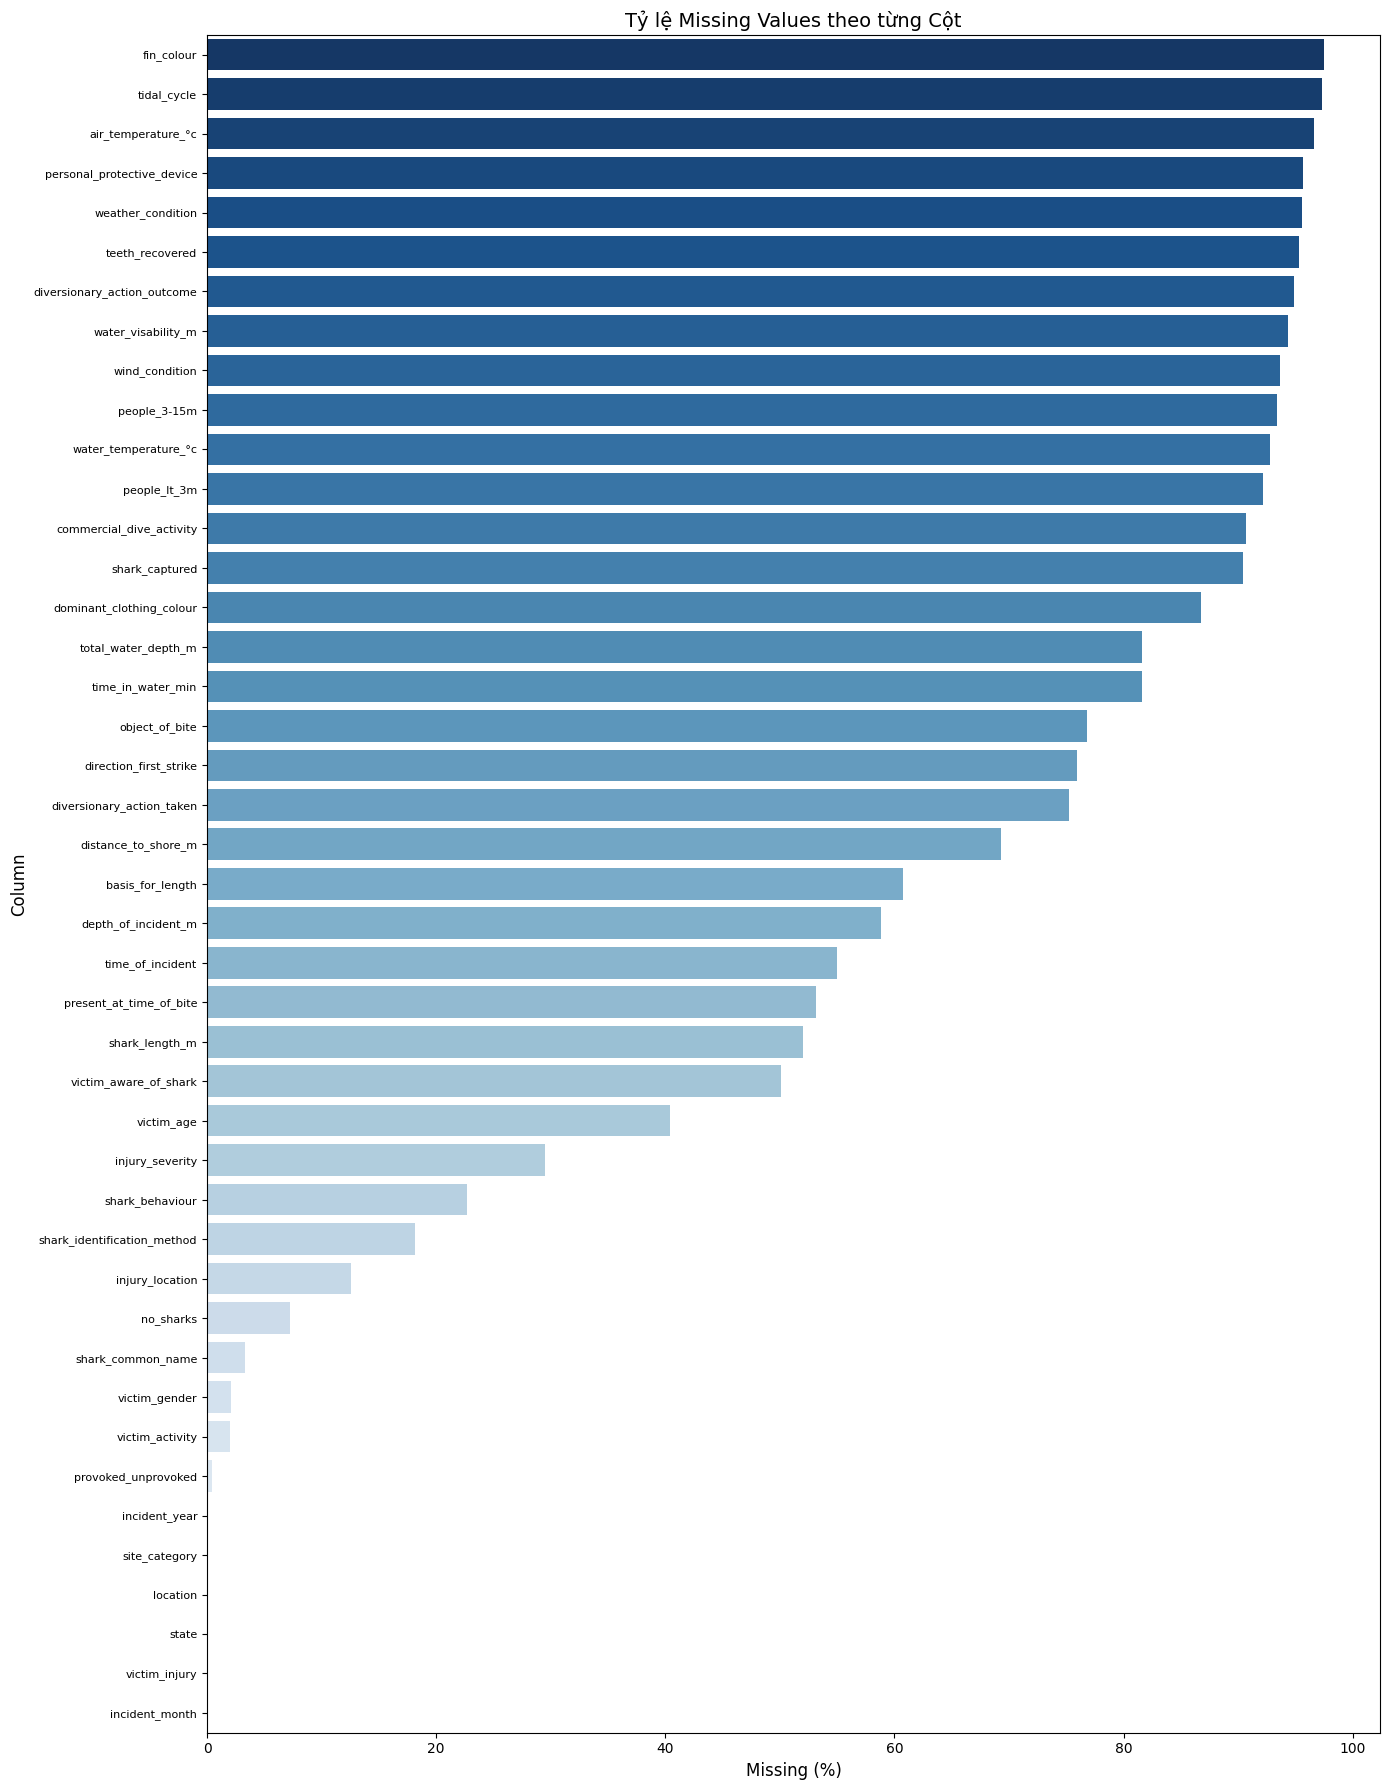

In [ ]:
# Thống kê missing value

missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().mean()*100).round(2)
}).sort_values(by="missing_percent", ascending=False)

print("\nBảng tổng hợp missing values:\n")
print(missing_summary)

print("\nBar Chart Missing Values theo từng cột:")
plt.figure(figsize=(14,18)) 
sns.barplot(
    data=missing_summary.reset_index(),
    x="missing_percent", y="index", palette="Blues_r"
)
plt.xlabel("Missing (%)", fontsize=12)
plt.ylabel("Column", fontsize=12)
plt.yticks(fontsize=8)       
plt.title("Tỷ lệ Missing Values theo từng Cột", fontsize=14)
plt.tight_layout()
plt.show()

Giá trị thiếu trong bộ dữ liệu này chủ yếu phát sinh từ tính chất lịch sử, rời rạc của quá trình thu thập và khó khăn trong việc quan sát tại hiện trường. Do đó, việc thiếu dữ liệu không phải mà mang tính hệ thống. 

Các cột thiếu nhiều nhất là các thông số chi tiết, khách quan, và khó đo lường.

In [ ]:
# Xử lí missing values
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Loại latitude/longitude vì có thể âm
invalid_numeric_cols = [
    c for c in num_cols
    if not any(x in c.lower() for x in ["latitude", "longitude"])
       and any(k in c.lower() for k in ["length", "age", "distance", 
                                       "total_water_depth", "visability", "people"])
]

# Xử lý âm và 0 chuyển thành -1 với các cột number và điền unkmowm đối cột categorical
for c in invalid_numeric_cols:
    df.loc[df[c] < 0, c] = np.nan
    # ngoại trừ cột depth_of_incident_m vì có thể là 0 (sự kiên xảy ra ngay mặt nước)
    if c.lower() not in ["depth_of_incident_m"]:
        df.loc[df[c] == 0, c] = np.nan

df[num_cols] = df[num_cols].fillna(-1)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df[cat_cols] = df[cat_cols].fillna("unknown")

#### Vì sao chọn cách thay giá trị này?

- Chọn thay missing value và các giá trị sai (âm hoặc bằng 0) của các cột số thành –1 và thay missing value của các cột phân loại thành “unknown” vì đây là dữ liệu ghi nhận thực tế. Nếu điền median hoặc mode sẽ tạo ra giá trị không có cơ sở và làm sai lệch dữ liệu gốc.

- Riêng cột depth_of_incident_m vẫn giữ giá trị 0 vì theo ngữ cảnh dữ liệu, 0 được xem là sự cố xảy ra ngay trên mặt nước hoặc sát bờ biển.

#### Phân tích các cột số

,mean,std,min,median,max
incident_month,5.915822,4.058937,1.0,5.00,12.0
incident_year,1970.664069,48.680308,1791.0,1989.00,2025.0
shark_length_m,2.682296,1.199854,0.3,2.60,6.0
no_sharks,1.032773,0.335359,1.0,1.00,10.0
victim_age,28.604194,14.253446,4.0,25.00,84.0
people_lt_3m,1.655914,1.542828,1.0,1.00,12.0
people_3-15m,3.273810,5.477998,1.0,2.00,40.0
time_of_incident,1278.057192,410.040299,130.0,1300.00,2330.0
depth_of_incident_m,2.193939,5.510993,0.0,0.00,45.0
time_in_water_min,59.725000,250.521424,0.1,10.00,2160.0


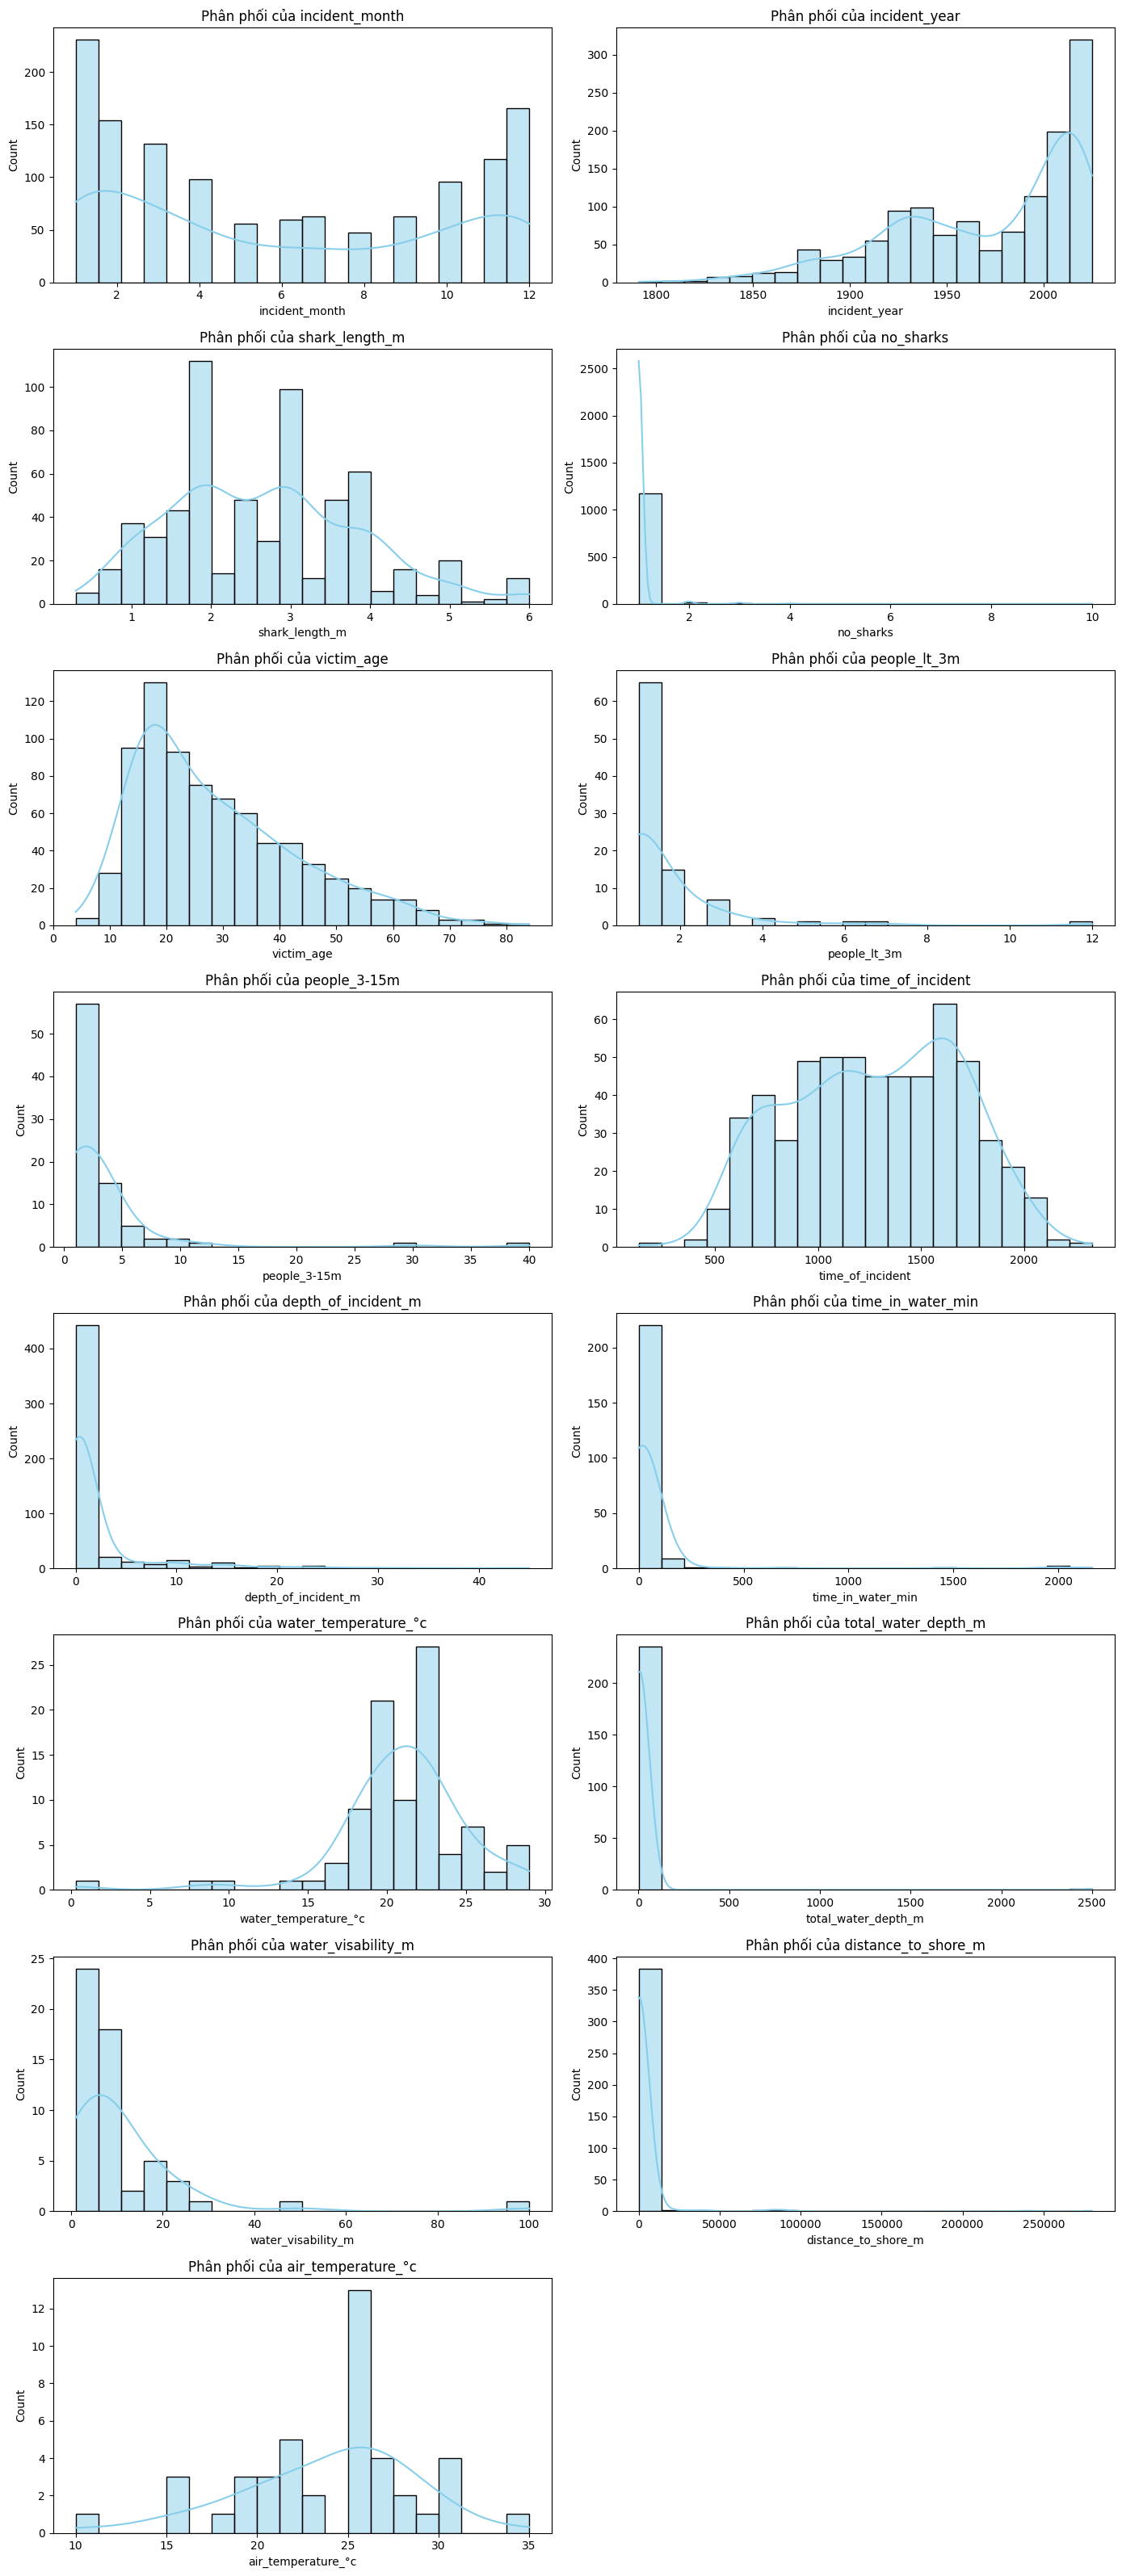

In [80]:
# Thống kê mô tả
stats_num_df = df[num_cols].replace(-1, np.nan).describe().transpose()
stats_num_df = stats_num_df[['mean','std','min','50%','max']]
stats_num_df.rename(columns={'50%':'median'}, inplace=True)
display(stats_num_df)

# Trực quan hóa 2 hình trên 1 dòng
n_cols = 2
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceil(len/2)
plt.figure(figsize=(14, n_rows * 4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    data_valid = df[col][df[col] != -1].dropna()
    if data_valid.empty:
        plt.title(f'Không có dữ liệu hợp lệ cho {col}')
        continue
    sns.histplot(data_valid, kde=True, bins=20, color='skyblue')
    plt.title(f'Phân phối của {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [81]:
# 04. Phân tích outlier

def detect_outliers(series):
    s = series[series != -1]  # bỏ -1 ra khỏi dữ liệu (các tường hợp missing được xử lí)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    out = s[(s < lower) | (s > upper)]
    return (len(out), len(out)/len(s)*100, s.min(), s.max(), lower, upper)

result = []
for col in df.select_dtypes(include=np.number).columns:
    count, rate, minv, maxv, low, up = detect_outliers(df[col])
    result.append([col, count, rate, minv, maxv, low, up])

outlier_df = pd.DataFrame(result, columns=[
    " Cột ", " Số lượng outlier ", " Tỷ lệ % ", 
    " Min ", " Max ", " Ngưỡng dưới ", " Ngưỡng trên "
])

print("Thống kê outlier:")
display(outlier_df)


Thống kê outlier:


,Cột,Số lượng outlier,Tỷ lệ %,Min,Max,Ngưỡng dưới,Ngưỡng trên
0,incident_month,0,0.000000,1.0,12.0,-10.000,22.000
1,incident_year,3,0.233827,1791.0,2025.0,1815.500,2131.500
2,shark_length_m,0,0.000000,0.3,6.0,-0.750,6.050
3,no_sharks,21,1.764706,1.0,10.0,1.000,1.000
4,victim_age,8,1.048493,4.0,84.0,-13.000,67.000
5,people_lt_3m,6,6.451613,1.0,12.0,-0.500,3.500
6,people_3-15m,7,8.333333,1.0,40.0,-2.000,6.000
7,time_of_incident,0,0.000000,130.0,2330.0,-105.000,2655.000
8,depth_of_incident_m,83,15.719697,0.0,45.0,-1.500,2.500
9,time_in_water_min,24,10.169492,0.1,2160.0,-37.500,70.500


### Nhận xét

1. Các cột số ổn định, ít hoặc không có outlier

- incident_month, incident_year, shark_length_m, time_of_incident, air_temperature_°c: hầu như không có outlier hoặc rất ít, dữ liệu hợp lý, đáng tin cậy để phân tích.

- Chiều dài cá mập (shark_length_m) có Mean ≈ 2.68 m, Median ≈ 2.6 m, Min = 0.3 m, Max = 6.1 m, phân bố khá cân bằng, phản ánh chủ yếu cá mập trưởng thành.

2. Các cột phản ánh tình huống thực tế

- victim_age: 8 outlier (~1%), gồm cả trẻ nhỏ (4 tuổi) và người già (84 tuổi), phản ánh các nạn nhân hiếm gặp. Median = 25, Mean = 28.6, phân bố lệch phải, chủ yếu nạn nhân ở nhóm thanh niên/người trẻ tuổi.

- depth_of_incident_m: 83 outlier (~15.7%), chủ yếu là vụ việc ở vùng nước rất nông hoặc sâu bất thường. Median = 0 m, Mean = 2.19 m, hầu hết các vụ tấn công xảy ra ở vùng nước nông, gần bờ.

- time_in_water_min: 24 outlier (~10%), phản ánh nạn nhân ở lại trong nước quá lâu hoặc rất ngắn.

- distance_to_shore_m: có outlier lớn (Max ≈ 280 km), Median = 80 m, Mean ≈ 2925 m, hầu hết vụ tấn công xảy ra gần bờ nhưng vẫn tồn tại các vụ biệt lập xa bờ.

- total_water_depth_m, no_sharks, people_lt_3m, people_3-15m, water_temperature_°c, water_visability_m: các outlier phần lớn xuất hiện trong những tình huống hiếm.

- Nhiệt độ nước (water_temperature_°c): phân bố cân bằng, Median ≈ 21°C, Mean ≈ 21.01°C, phần lớn các vụ xảy ra trong điều kiện nước ôn hòa/mát.

### Quyết định xử lý:

- Không loại outlier trong hầu hết các cột vì nhiều trường hợp phản ánh tình huống thực tế của sự kiện tấn công cá mập.

- Các cột như distance_to_shore_m, latitude, depth_of_incident_m, time_in_water_min, total_water_depth_m giữ nguyên giá trị outlier vì phản ánh các tình huống thực tế hiếm gặp, cần thiết cho phân tích hành vi và bối cảnh tấn công.

### Phân tích các cột phân loại

In [82]:
# Chuẩn hóa text
for col in cat_cols:
    df[col] = df[col].str.lower().str.strip()

# Bảng thống kê chung cho tất cả cột phân loại
summary_list = []
for col in cat_cols:
    df_valid = df[df[col] != 'unknown']
    value_counts = df_valid[col].value_counts(normalize=True).head(5) * 100
    top_values = ", ".join([f"{idx} ({v:.1f}%)" for idx, v in value_counts.items()])
    summary_list.append({
        "Cột": col,
        "Số giá trị trong cột": df[col].nunique(),
        "Top 5 giá trị xuất hiện nhiều nhất": top_values
    })
summary_cat_df = pd.DataFrame(summary_list)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
display(summary_cat_df)

,Cột,Số giá trị trong cột,Top 5 giá trị xuất hiện nhiều nhất
0,victim_injury,5,"injured (60.6%), fatal (20.2%), uninjured (19.1%), injury (0.1%)"
1,state,7,"nsw (35.9%), qld (29.4%), wa (18.9%), sa (6.5%), vic (5.7%)"
2,location,893,"torres strait, unknown location (1.2%), townsville, ross creek (0.8%), sydney, maroubra beach (0.8%), torres strait, badu island (0.6%), moreton bay (0.5%)"
3,site_category,8,"coastal (65.8%), island open ocean (14.4%), estuary/harbour (8.0%), river (7.5%), ocean/pelagic (4.1%)"
4,shark_common_name,27,"white shark (31.3%), tiger shark (19.2%), wobbegong (17.6%), bull shark (17.3%), whaler shark (6.4%)"
5,shark_identification_method,34,"bite analysis, shark behaviour, geographical location (25.0%), direct observation (21.4%), bite analysis, shark behaviour, geographical location, direct observation (16.8%), bite analysis (9.1%), bite analysis, shark behaviour (8.5%)"
6,basis_for_length,23,"witness/victim (65.7%), other: media report (8.9%), government official (6.5%), bite radius estimation (6.3%), other: measured captured shark (3.8%)"
7,provoked_unprovoked,3,"unprovoked (67.2%), provoked (32.8%)"
8,victim_activity,28,"swimming (37.4%), boarding (22.4%), spearfishing (10.5%), snorkelling (10.4%), diving (7.2%)"
9,commercial_dive_activity,4,"y (98.3%), board (0.8%), n (0.8%)"


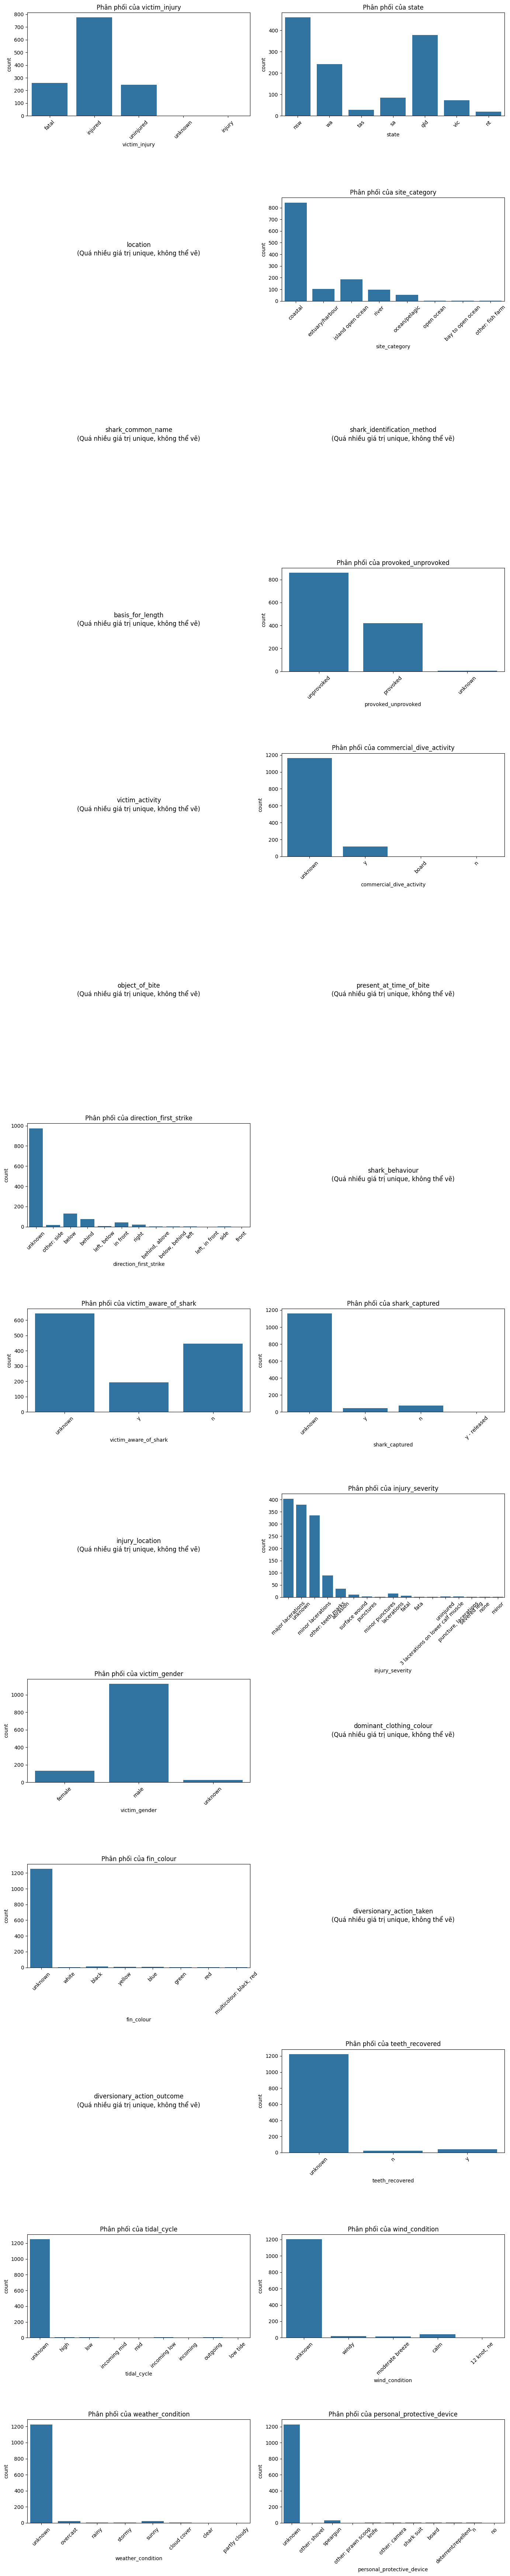

In [83]:
n = len(cat_cols)
ncols = 2
nrows = math.ceil(n / 2)
plt.figure(figsize=(14, 5 * nrows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(nrows, ncols, i)

    # Không vẽ những cột có quá nhiều giá trị
    if df[col].nunique() > 20:
        plt.text(0.5, 0.5,
                 f"{col}\n(Quá nhiều giá trị unique, không thể vẽ)",
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
        continue

    sns.countplot(data=df, x=col)
    plt.title(f"Phân phối của {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

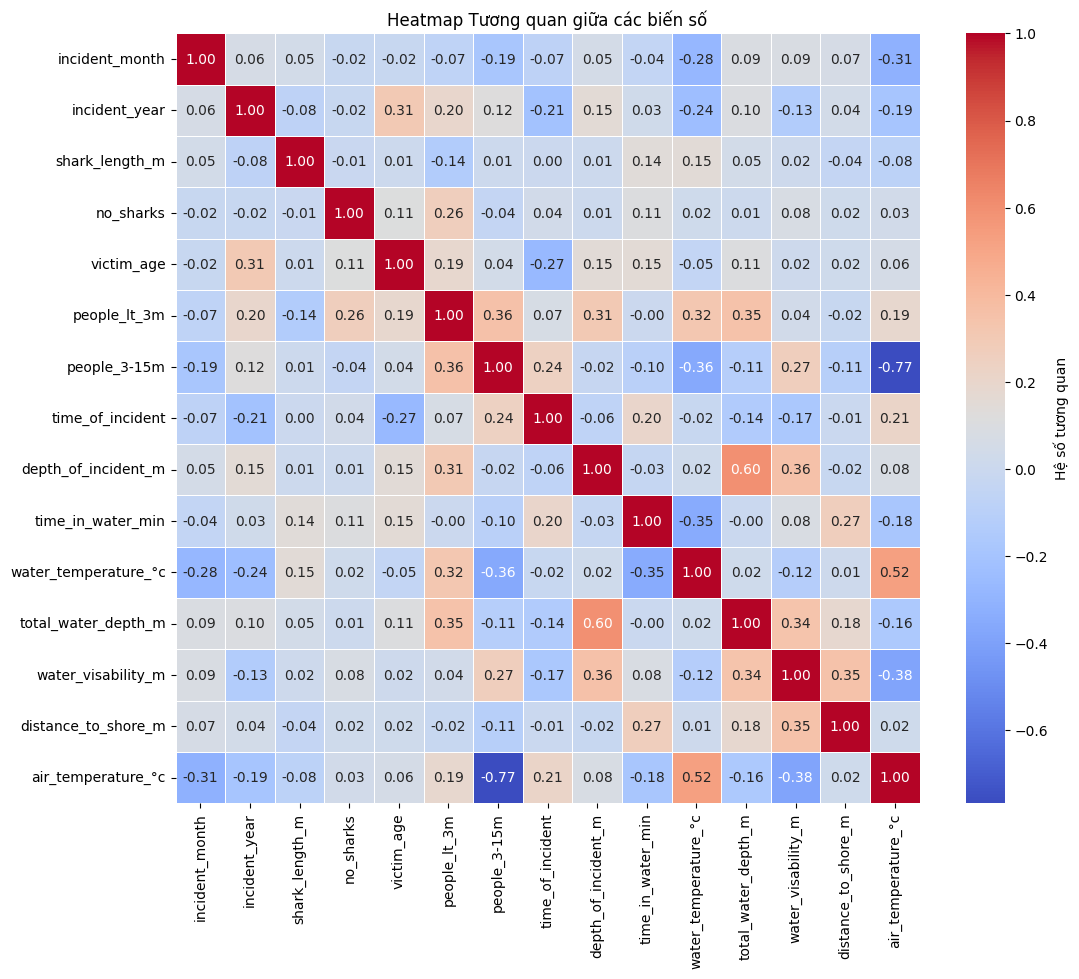

In [84]:
# Phân tích mối quan hệ & tương quan
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# loại biến hầu hết là -1
valid_num_cols = [c for c in num_cols if (df[c] != -1).sum() > 10]
corr_matrix = df[valid_num_cols].replace(-1, np.nan).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Hệ số tương quan'}
)
plt.title('Heatmap Tương quan giữa các biến số')
plt.show()


#### Nhận xét:

Các Mối Tương Quan Mạnh: $|r| \ge 0.5$)
- people_3-15m và air_temperature_°c (r = -0.77)
    - Tương quan âm rất mạnh (mối quan hệ mạnh nhất trong tập dữ liệu).
    - Khi nhiệt độ không khí tăng cao, số lượng người ở khu vực gần bờ (3–15 mét) lại có xu hướng giảm xuống. Điều này đi ngược lại trực giác thông thường (trời nóng thì đông người xuống biển hơn). 
    - Giải thích: khi trời quá nóng, người tắm biển có xu hướng bơi ra các vùng nước sâu hơn (xa bờ hơn 15 mét) để tìm kiếm nước mát hơn hoặc không gian rộng hơn, làm giảm mật độ ở khu vực gần bờ.
- total_water_depth_m và depth_of_incident_m (r = 0.60)
    - Tổng độ sâu của khu vực có liên quan chặt chẽ đến độ sâu nơi sự cố cá mập xảy ra.
    - Đây là mối quan hệ vật lý hợp lý, xác nhận tính nhất quán về dữ liệu địa lý, nơi tổng thể nước sâu thì sự cố có xu hướng xảy ra ở độ sâu lớn hơn.
- air_temperature_°c vs. water_temperature_°c (r = 0.52)
    - Nhiệt độ không khí cao có mối quan hệ trực tiếp với nhiệt độ nước.
    - Mối quan hệ môi trường này cho thấy các sự cố cá mập (và hoạt động của con người) thường tập trung vào các mùa có điều kiện nhiệt độ ấm áp.
Các Biến Tương Quan Yếu: Hầu hết các biến khác đều có tương quan yếu ($|r| < 0.2$), đặc biệt là các biến liên quan trực tiếp đến sinh vật học và độ sâu chính xác của sự cố như:
- shark_length_m: Tương quan gần bằng 0 với hầu hết các yếu tố môi trường và hành vi, kích thước của cá mập được ghi nhận không liên quan tuyến tính đến các biến khác.
- victim_age: Có tương quan yếu với tất cả các biến số khác, tuổi của nạn nhân không liên quan nhiều đến các yếu tố môi trường hay hành vi.
- no_sharks: Tương quan yếu, cho thấy phần lớn các sự cố được ghi nhận là các cuộc tấn công đơn lẻ, không liên quan trực tiếp đến số lượng cá mập được quan sát trong khu vực lân cận.

In [85]:
# Lưu dữ liệu đã xử lý

out_dir = "data/processed"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "SharkIncident_processed.csv")
df.to_csv(out_path, index=False)